In [1]:
import pandas as pd
import numpy as np
import pickle
import time
from collections import defaultdict
import seaborn as sns

/data/software/Anaconda3/4.4.0-foss-2017a/envs/deeplift/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1. Load model

In [2]:
model_ls = [['TLand', pickle.load(open('../../benchmarking/data/models/TLand_organSp.pickle','rb'))], 
            ['TLand_light', pickle.load(open('../../benchmarking/data/models/TLand_organSp_light.pickle','rb'))], 
            ['TLand_lightest', pickle.load(open('../../benchmarking/data/models/TLand_organSp_lightest.pickle','rb'))]]

### 2. Load features

In [3]:
organ_ls = []
with open('../../benchmarking/data/organ_list.txt') as file:
    for line in file:
        line = line.strip()
        organ_ls.append(line)

In [4]:
pred_dict = defaultdict(list)
for i, organ in enumerate(organ_ls[:1]):
    print(i, organ)
    start = time.time()
    
    
    # get features
    with open('../data/df_all_temp.pickle', 'rb') as file:
        df_all = pickle.load(file)
    
    input_features = pd.read_csv(f'../data/organsp_features_regdb/{organ}.txt', sep='\t')
    df_all = pd.merge(df_all, 
                  input_features.drop_duplicates(subset=['chrom', 'end']), 
                  left_on=['chrom', 'end'], right_on=['chrom', 'end'], how='left')
    
    input_features = pd.read_csv(f'../data/organsp_features_dnase/{organ}.txt', sep='\t')
    df_all = pd.concat([df_all, input_features], axis=1)
    
    input_features = pd.read_csv(f'../data/organsp_features_histone/{organ}.txt', sep='\t')
    df_all = pd.merge(df_all, 
                  input_features.drop_duplicates(subset=['chrom', 'end']), 
                  left_on=['chrom', 'end'], right_on=['chrom', 'end'], how='left')
    
    input_features = pd.read_csv(f'../data/organsp_features_ctcf/{organ}.txt', sep='\t')
    df_all = pd.merge(df_all, 
                  input_features.drop_duplicates(subset=['chrom', 'end']), 
                  left_on=['chrom', 'end'], right_on=['chrom', 'end'], how='left')
    
    
    # make prediction
    for model in model_ls:
        pred_dict[model[0]].append(model[1].predict_proba(df_all)[:, 1]) #change model name
    
    
    print(time.time()-start)

0 adipose tissue
259.23216938972473


In [ ]:
for model in model_ls:
    output_df = df_all[['chrom', 'end', 'name', 'ref', 'alt']].copy()
    for i, organ in enumerate(organ_ls[:1]):
        output_df[organ] = pred_dict[model[0]][i]
#     output_df.to_csv(f'../data/gwas_prediction/{model[0]}.txt', sep='\t', index=None)

In [25]:
adipose_3models= pd.concat([pd.read_csv('../data/gwas_prediction/TLand.txt', sep='\t').rename(columns={
                                'adipose tissue': 'TLand'})[['chrom','end','name','ref','alt','TLand']], 
                            pd.read_csv('../data/gwas_prediction/TLand_light.txt', sep='\t').rename(columns={
                                'adipose tissue':'TLand_light'})['TLand_light'],
                            pd.read_csv('../data/gwas_prediction/TLand_lightest.txt', sep='\t').rename(columns={
                                'adipose tissue':'TLand_lightest'})['TLand_lightest']], axis=1)
adipose_3models

,chrom,end,name,ref,alt,TLand,TLand_light,TLand_lightest
0,chr1,796784,1:796784,T,G,0.126280,0.142579,0.284113
1,chr1,804610,1:804610,G,A,0.141008,0.174163,0.204757
2,chr1,832873,1:832873,A,C,0.121847,0.143124,0.163374
3,chr1,845017,1:845017,C,T,0.193465,0.184999,0.153459
4,chr1,873251,1:873251,G,A,0.131483,0.140302,0.430525
...,...,...,...,...,...,...,...,...
1974544,chrX,155625120,X:155625120,T,A,0.158768,0.182777,0.182320
1974545,chrX,155675419,X:155675419,T,C,0.293158,0.217881,0.194150
1974546,chrX,155749677,X:155749677,T,C,0.139696,0.132763,0.135752
1974547,chrX,155757485,X:155757485,T,C,0.317588,0.376638,0.616926


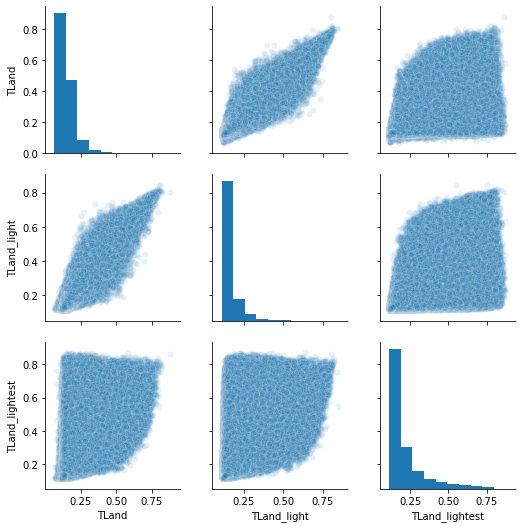

In [28]:
sns.pairplot(adipose_3models[['TLand', 'TLand_light', 'TLand_lightest']], plot_kws=dict(alpha=0.1))